In [1]:
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import numpy
from mpl_toolkits import mplot3d
from matplotlib import cm
from math import factorial
sys.path.append("FixedStrides")
from main import *
from ast import literal_eval
results_wolant = pd.read_csv('ip32_wolant_results.csv', sep=';')
results_fst = pd.read_csv('ip32_fst_results.csv', sep=';')
results_random_shuffled = pd.read_csv('ip32_random_shuffled.csv', sep=';')
all_configs_5_strides = pd.read_csv('all_configs_5_strides.csv', sep=';')
thesis_example = pd.read_csv('prefixes_from_thesis.csv', sep=';')
# results_au = pd.read_csv('ipResults_home_gtx980_australia.csv', sep=';')
# results_au_32bit = pd.read_csv('ip_32bit_au.csv', sep=';')
# results_tokyo = pd.read_csv('ip_32bit_tokyo.csv', sep=';')
# results_au_32bit.drop(results_au_32bit.columns[len(results_au_32bit.columns)-1], axis=1, inplace=True)  # delete NaN column
# results_tokyo.drop(results_tokyo.columns[len(results_tokyo.columns)-1], axis=1, inplace=True)  # delete NaN column

In [2]:
def plot_prefix_distribution(prefixes):
    lengths = utils.get_lengths(prefixes)
    plt.bar(range(1, len(lengths) + 1), lengths, align='center')
    plt.xlabel('Prefix length in bits')
    plt.ylabel('Num occurrences')
    plt.title('Prefix length distribution')
    plt.show()

In [3]:
# prefixes_au = utils.get_prefixes_from_file(file_name='FixedStrides/data/data-raw-table_australia_012016.txt')
prefixes_tokyo = utils.get_prefixes_from_file(file_name='FixedStrides/data/data-raw-table_tokyo_012016.txt')
node_counts_tokyo = utils.get_node_counts(prefixes_tokyo)

Read 576846 prefixes from file in 7.533643007278442 seconds


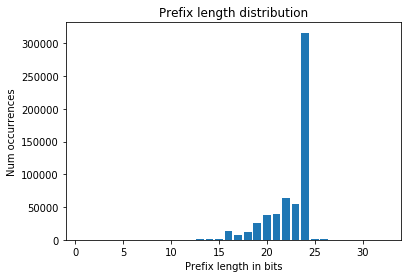

In [4]:
# plot_prefix_distribution(prefixes_au)
plot_prefix_distribution(prefixes_tokyo)

In [5]:
# Converts string that look like this: "{1, 2, 3, 4, 5}" to list of ints: [1, 2, 3, 4 ,5]
def from_curly_bracket_str_to_list(curly_bracket_str: str):
    tmp = curly_bracket_str.replace('{', ' ').replace('}',' ').replace(',',' ').split()
    return [literal_eval(x) for x in tmp]

def append_stats(row: pd.Series, nodes: list):
    strides = from_curly_bracket_str_to_list(row['Config'])
    tree_levels = from_curly_bracket_str_to_list(row['TreeLevels'])
    num_empty_pointers_per_lvl, percentage_empty_pointers_per_lvl, total_empty_pointer_percentage = utils.get_empty_node_stats(tree_levels, strides)
    num_empty_pointers_per_lvl = str(num_empty_pointers_per_lvl)
    percentage_empty_pointers_per_lvl = str(percentage_empty_pointers_per_lvl)
    tmp, strides_nodes, cost, percent = utils.get_stats(nodes, strides, ignore_last_level=True)
    max_avg_node_size = max(from_curly_bracket_str_to_list(row['AverageNodeSizesLevels']))
    build_and_find = float(row['Build']) + float(row['Find'])
    build_and_match = float(row['Build']) + float(row['Match'])
    match_and_find = float(row['Match']) + float(row['Find'])
    return pd.Series([cost, percent, build_and_find, build_and_match, match_and_find, num_empty_pointers_per_lvl, percentage_empty_pointers_per_lvl, total_empty_pointer_percentage, max_avg_node_size])

def append_stats_to_df(df: pd.DataFrame):
    newcol_names = ['Cost', 'Percent', 'BuildAndFind', 'BuildAndMatch', 'MatchAndFind', 'EmptyPointerLevels', 'PercentEmptyPointerLevels', 'TotalEmptyPointerPercentage', 'MaxAverageNodeSize']
    # For now assume Tokyo dataset
    newcols = df.apply(lambda row: append_stats(row, node_counts_tokyo), axis=1)
    newcols.columns = newcol_names
    return df.join(newcols)

In [6]:
results_wolant = append_stats_to_df(results_wolant)
results_fst = append_stats_to_df(results_fst)
results_random_shuffled = append_stats_to_df(results_random_shuffled)
all_configs_5_strides = append_stats_to_df(all_configs_5_strides)
thesis_example = append_stats_to_df(thesis_example)

In [7]:
results_wolant = results_wolant.sort_values('RandomMatch')
results_wolant[['Config', 'MaxNodeSize', 'MaxAverageNodeSize', 'AverageNodeSize', 'RandomMatch', 'Match','TreeMemoryUniqueOnly', 'Build', 'EmptyPointerLevels']]

,Config,MaxNodeSize,MaxAverageNodeSize,AverageNodeSize,RandomMatch,Match,TreeMemoryUniqueOnly,Build,EmptyPointerLevels
12,"{1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",12974,20.561,7.42478,0.604064,2.10973,3551560,89.2066,"[0, 0, 0, 2, 3, 18, 26, 35, 30, 34, 33, 48, 72..."
11,"{8, 2, 2, 2, 2, 2, 2, 2, 2, 8}",14744,36.226,20.90630,0.614240,1.53203,2946048,37.5439,"[215, 94, 114, 257, 683, 1849, 2646, 2918, 68017]"
7,"{8, 4, 4, 2, 2, 2, 2, 8}",16266,97.988,21.27410,0.618784,1.46784,2944456,29.3938,"[215, 490, 1711, 1849, 2646, 2918, 68017]"
2,"{8, 4, 4, 4, 4, 8}",16266,97.988,74.04960,0.667040,1.60717,2769680,24.5993,"[215, 490, 1711, 10042, 79689]"
10,"{4, 5, 4, 5, 6, 4, 2, 2}",22871,278.908,148.51900,1.120320,3.99101,2972080,28.7000,"[2, 396, 572, 6389, 122025, 24898, 163]"
9,"{4, 4, 4, 4, 8, 8}",17144,591.096,211.60900,1.501410,10.83330,3311312,22.0528,"[2, 183, 490, 1711, 240361]"
3,"{8, 8, 2, 2, 2, 2, 8}",16680,406.829,21.40510,8.301570,1.05174,2971824,27.9162,"[215, 9551, 1849, 2646, 2918, 68017]"
5,"{8, 8, 4, 4, 8}",16680,406.829,75.66190,8.305120,1.59578,2797048,19.8685,"[215, 9551, 10042, 79689]"
6,"{8, 8, 4, 2, 2, 8}",16680,406.829,23.05720,8.320320,1.07987,2970800,23.3692,"[215, 9551, 10042, 2918, 68017]"
8,"{8, 8, 16}",17145,592.751,584.44400,9.154400,10.62030,2358400,16.7501,"[215, 9551]"


In [8]:
results_fst = results_fst.sort_values('RandomMatch')
results_fst[['Config', 'MaxNodeSize', 'MaxAverageNodeSize', 'AverageNodeSize', 'RandomMatch', 'Match','TreeMemoryUniqueOnly', 'Build', 'EmptyPointerLevels']]

,Config,MaxNodeSize,MaxAverageNodeSize,AverageNodeSize,RandomMatch,Match,TreeMemoryUniqueOnly,Build,EmptyPointerLevels
12,"{1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",12974,20.561,7.42478,0.551200,3.030050,3551560,81.5850,"[0, 0, 0, 2, 3, 18, 26, 35, 30, 34, 33, 48, 72..."
10,"{8, 4, 4, 2, 2, 2, 1, 1, 2, 1, 2, 3}",16266,97.988,9.39045,0.630976,1.188060,3379696,36.7002,"[215, 490, 1711, 1849, 2646, 2918, 1009, 65999..."
11,"{8, 4, 4, 2, 2, 2, 1, 1, 1, 1, 1, 2, 3}",16266,97.988,9.23752,0.670208,1.242660,3383536,39.9926,"[215, 490, 1711, 1849, 2646, 2918, 1009, 65999..."
0,"{3, 5, 4, 4, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2}",16266,97.988,20.06980,1.034080,1.522460,2983040,54.2235,"[0, 215, 490, 1711, 1849, 2646, 2918, 68017, 2..."
7,"{12, 4, 2, 2, 2, 1, 1, 3, 5}",16266,430.000,9.46953,1.481950,1.029730,3408608,28.5985,"[3930, 1711, 1849, 2646, 2918, 1009, 65999, 12..."
9,"{12, 4, 2, 2, 2, 1, 1, 2, 1, 2, 3}",16266,430.000,9.39672,1.553630,1.110270,3392064,37.2323,"[3930, 1711, 1849, 2646, 2918, 1009, 65999, 57..."
8,"{12, 4, 2, 2, 2, 1, 1, 2, 2, 4}",16266,430.000,9.40392,1.560960,1.011710,3394176,31.3502,"[3930, 1711, 1849, 2646, 2918, 1009, 65999, 57..."
6,"{13, 4, 3, 2, 1, 1, 3, 5}",19623,936.000,9.70239,2.653380,0.850592,3415496,29.0179,"[7932, 2840, 5482, 2918, 1009, 65999, 12409]"
5,"{17, 3, 2, 1, 1, 3, 5}",24107,24107.000,9.74501,45.064400,0.930080,3888256,24.3748,"[129752, 5482, 2918, 1009, 65999, 12409]"
4,"{17, 3, 2, 1, 1, 8}",24107,24107.000,9.75539,45.877700,0.913184,3837824,22.3475,"[129752, 5482, 2918, 1009, 65999]"


In [9]:
results_random_shuffled = results_random_shuffled.sort_values('RandomMatch')
results_random_shuffled[['Config', 'MaxNodeSize', 'MaxAverageNodeSize', 'AverageNodeSize', 'RandomMatch', 'Match','TreeMemoryUniqueOnly', 'Build', 'EmptyPointerLevels']]

,Config,MaxNodeSize,MaxAverageNodeSize,AverageNodeSize,RandomMatch,Match,TreeMemoryUniqueOnly,Build,EmptyPointerLevels
701,"{7, 2, 2, 5, 4, 2, 2, 5, 3}",16531,154.4950,22.8871,0.387296,1.15347,3144600,27.5663,"[90, 100, 101, 2479, 10042, 2918, 68017, 49858]"
518,"{3, 7, 1, 1, 5, 4, 11}",20129,142.6330,53.1215,0.387968,1.20211,2505800,23.6289,"[0, 954, 33, 48, 3992, 11933]"
599,"{6, 5, 4, 1, 3, 3, 3, 7}",12974,48.2402,24.9415,0.388416,1.08160,3191848,25.3618,"[32, 917, 1081, 317, 4559, 6614, 138135]"
777,"{8, 2, 1, 2, 4, 4, 2, 3, 6}",19623,89.1192,12.7601,0.391616,1.08659,4002384,28.8361,"[215, 94, 33, 168, 2840, 11933, 2969, 269790]"
920,"{7, 3, 1, 5, 1, 1, 2, 3, 1, 7, 1}",16531,154.4950,12.8620,0.394016,1.14406,3962544,32.3216,"[90, 234, 33, 2479, 570, 709, 2646, 6845, 6599..."
...,...,...,...,...,...,...,...,...,...
135,"{24, 1, 7}",575282,575282.0000,223.8440,1168.940000,2746.03000,69449448,19.4805,"[16775657, 2101]"
256,"{24, 3, 3, 2}",575282,575282.0000,350.8800,1169.340000,2740.35000,69481456,22.0818,"[16775657, 12409, 483]"
132,"{24, 3, 5}",575282,575282.0000,355.4200,1171.440000,1734.92000,69479232,19.4242,"[16775657, 12409]"
159,"{24, 4, 4}",575282,575282.0000,359.1820,2167.200000,1726.66000,69528984,20.4235,"[16775657, 24898]"


In [10]:
all_configs_5_strides = all_configs_5_strides.sort_values('RandomMatch')
all_configs_5_strides[['Config', 'MaxNodeSize', 'MaxAverageNodeSize', 'AverageNodeSize', 'RandomMatch', 'Match','TreeMemoryUniqueOnly', 'Build', 'EmptyPointerLevels']]

,Config,MaxNodeSize,MaxAverageNodeSize,AverageNodeSize,RandomMatch,Match,TreeMemoryUniqueOnly,Build,EmptyPointerLevels
22755,"{9, 2, 5, 6, 10}",16531,198.196,31.1826,0.366400,1.13853,2714064,18.5996,"[460, 101, 2479, 43086]"
9603,"{3, 8, 5, 6, 10}",16531,198.196,31.2569,0.371488,1.12803,2719056,19.2218,"[0, 1941, 2479, 43086]"
19444,"{7, 4, 5, 6, 10}",16531,198.196,31.2062,0.373728,1.19834,2714016,18.9324,"[90, 501, 2479, 43086]"
15119,"{5, 6, 5, 5, 11}",16531,154.495,56.1954,0.376032,1.11466,2530880,18.3096,"[7, 1493, 2479, 21053]"
17420,"{6, 5, 5, 6, 10}",16531,198.196,31.2163,0.383584,1.16480,2715376,19.2734,"[32, 917, 2479, 43086]"
...,...,...,...,...,...,...,...,...,...
31267,"{24, 1, 4, 1, 2}",575282,575282.000,219.5000,1171.440000,1737.75000,69515264,24.7948,"[16775657, 2101, 16242, 39]"
31257,"{24, 1, 1, 3, 3}",575282,575282.000,189.1920,1171.990000,1727.64000,69475584,25.8422,"[16775657, 2101, 1592, 3506]"
31287,"{24, 4, 1, 2, 1}",575282,575282.000,348.1270,1172.090000,1740.06000,69530320,25.1917,"[16775657, 24898, 62, 99]"
31285,"{24, 3, 3, 1, 1}",575282,575282.000,346.4540,1172.260000,1737.49000,69481832,27.2210,"[16775657, 12409, 483, 21]"


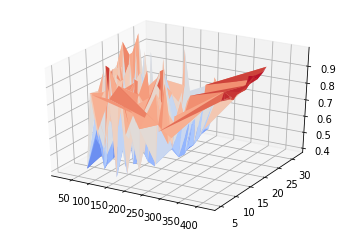

In [11]:
x = results_random_shuffled['MaxAverageNodeSize'].values
y = results_random_shuffled['TreeHeight'].values
z = results_random_shuffled['RandomMatch'].values
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_trisurf(x[z < 1], y[z < 1], z[z < 1], cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)

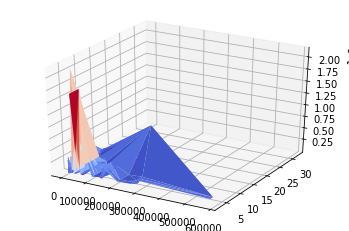

In [12]:
x = results_random_shuffled['MaxAverageNodeSize'].values
y = results_random_shuffled['TreeHeight'].values
z = results_random_shuffled['TreeMemoryUniqueOnly'].values
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_trisurf(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)


,AverageNodeSize,RandomMatch
701,22.8871,0.387296
518,53.1215,0.387968
599,24.9415,0.388416
777,12.7601,0.391616
920,12.8620,0.394016
...,...,...
135,223.8440,1168.940000
256,350.8800,1169.340000
132,355.4200,1171.440000
159,359.1820,2167.200000


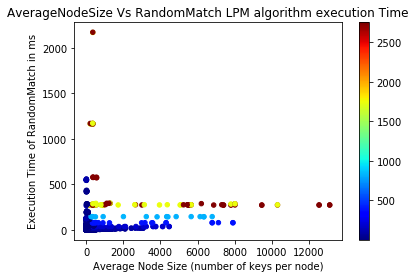

In [13]:
x = results_random_shuffled['AverageNodeSize'].values
y = results_random_shuffled['RandomMatch'].values
z = results_random_shuffled['Match'].values
plt.title("AverageNodeSize Vs RandomMatch LPM algorithm execution Time")
plt.xlabel("Average Node Size (number of keys per node)")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()

results_random_shuffled = results_random_shuffled.sort_values('RandomMatch')
results_random_shuffled[['AverageNodeSize', 'RandomMatch']]

,AverageNodeSize,RandomMatch
22755,31.1826,0.366400
9603,31.2569,0.371488
19444,31.2062,0.373728
15119,56.1954,0.376032
17420,31.2163,0.383584
...,...,...
31267,219.5000,1171.440000
31257,189.1920,1171.990000
31287,348.1270,1172.090000
31285,346.4540,1172.260000


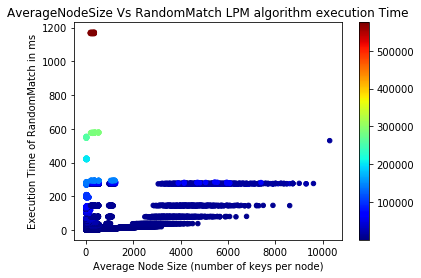

In [14]:
x = all_configs_5_strides['AverageNodeSize'].values
y = all_configs_5_strides['RandomMatch'].values
z = all_configs_5_strides['MaxAverageNodeSize'].values
plt.title("AverageNodeSize Vs RandomMatch LPM algorithm execution Time")
plt.xlabel("Average Node Size (number of keys per node)")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()

all_configs_5_strides = all_configs_5_strides.sort_values('RandomMatch')
all_configs_5_strides[['AverageNodeSize', 'RandomMatch']]

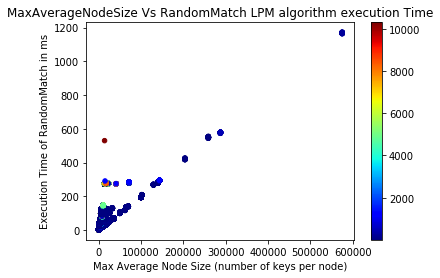

In [15]:
x = all_configs_5_strides['MaxAverageNodeSize'].values
y = all_configs_5_strides['RandomMatch'].values
z = all_configs_5_strides['AverageNodeSize'].values
plt.title("MaxAverageNodeSize Vs RandomMatch LPM algorithm execution Time")
plt.xlabel("Max Average Node Size (number of keys per node)")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()

# all_configs_5_strides = all_configs_5_strides.sort_values('MaxAverageNodeSize')
# all_configs_5_strides[['MaxAverageNodeSize', 'RandomMatch']][all_configs_5_strides['RandomMatch'] > 500]

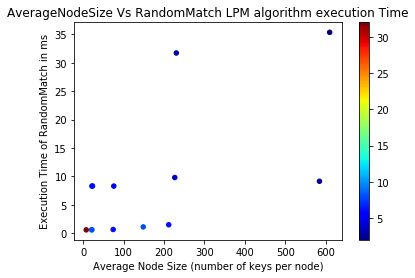

In [16]:
x = results_wolant['AverageNodeSize'].values
y = results_wolant['RandomMatch'].values
z = results_wolant['Depth'].values
plt.title("AverageNodeSize Vs RandomMatch LPM algorithm execution Time")
plt.xlabel("Average Node Size (number of keys per node)")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()

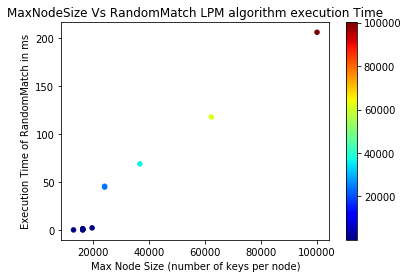

In [17]:
# Seems logarithmic in complexity, normal shape
# Conclusion- PSFT/FST algorithm give us consistency?
x = results_fst['MaxNodeSize'].values
y = results_fst['RandomMatch'].values
z = results_fst['MaxAverageNodeSize'].values
plt.title("MaxNodeSize Vs RandomMatch LPM algorithm execution Time")
plt.xlabel("Max Node Size (number of keys per node)")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()

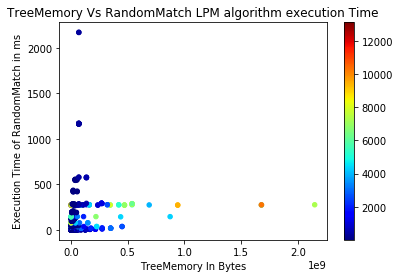

In [18]:
x = results_random_shuffled['TreeMemoryUniqueOnly'].values
y = results_random_shuffled['RandomMatch'].values
z = results_random_shuffled['AverageNodeSize'].values
plt.title("TreeMemory Vs RandomMatch LPM algorithm execution Time")
plt.xlabel("TreeMemory In Bytes")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()

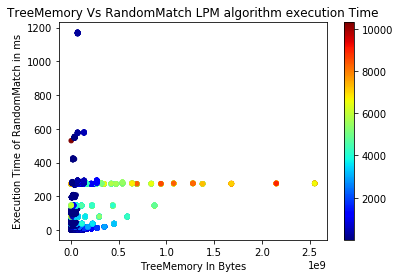

In [19]:
x = all_configs_5_strides['TreeMemoryUniqueOnly'].values
y = all_configs_5_strides['RandomMatch'].values
z = all_configs_5_strides['AverageNodeSize'].values
plt.title("TreeMemory Vs RandomMatch LPM algorithm execution Time")
plt.xlabel("TreeMemory In Bytes")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()

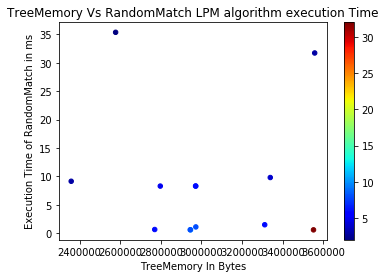

In [20]:
# Completely random
x = results_wolant['TreeMemoryUniqueOnly'].values
y = results_wolant['RandomMatch'].values
z = results_wolant['Depth'].values
plt.title("TreeMemory Vs RandomMatch LPM algorithm execution Time")
plt.xlabel("TreeMemory In Bytes")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()

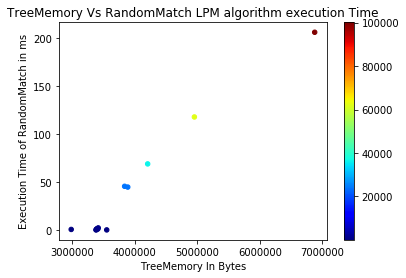

In [21]:
x = results_fst['TreeMemoryUniqueOnly'].values
y = results_fst['RandomMatch'].values
z = results_fst['MaxAverageNodeSize'].values
plt.title("TreeMemory Vs RandomMatch LPM algorithm execution Time")
plt.xlabel("TreeMemory In Bytes")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()


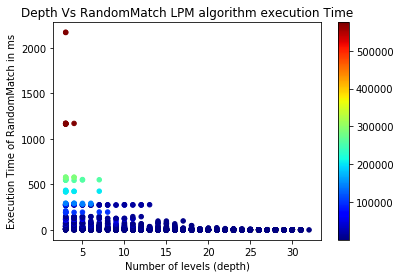

In [22]:
x = results_random_shuffled['Depth'].values
y = results_random_shuffled['RandomMatch'].values
z = results_random_shuffled['MaxAverageNodeSize'].values
plt.title("Depth Vs RandomMatch LPM algorithm execution Time")
plt.xlabel("Number of levels (depth)")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()

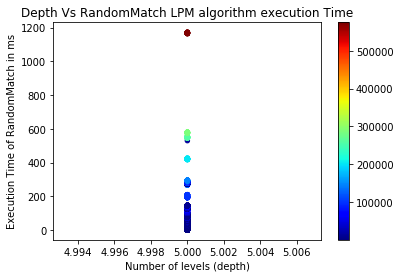

In [23]:
x = all_configs_5_strides['Depth'].values
y = all_configs_5_strides['RandomMatch'].values
z = all_configs_5_strides['MaxAverageNodeSize'].values
plt.title("Depth Vs RandomMatch LPM algorithm execution Time")
plt.xlabel("Number of levels (depth)")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()

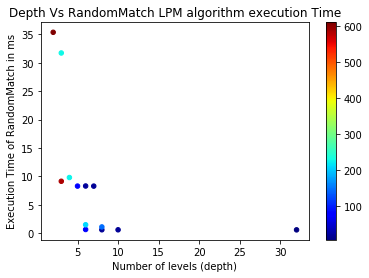

In [24]:
x = results_wolant['Depth'].values
y = results_wolant['RandomMatch'].values
z = results_wolant['AverageNodeSize'].values
plt.title("Depth Vs RandomMatch LPM algorithm execution Time")
plt.xlabel("Number of levels (depth)")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()

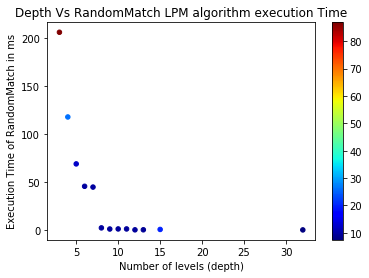

In [25]:
x = results_fst['Depth'].values
y = results_fst['RandomMatch'].values
z = results_fst['AverageNodeSize'].values
plt.title("Depth Vs RandomMatch LPM algorithm execution Time")
plt.xlabel("Number of levels (depth)")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()

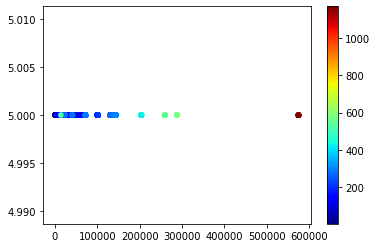

In [26]:
x = all_configs_5_strides['MaxAverageNodeSize'].values
y = all_configs_5_strides['Depth'].values
z = all_configs_5_strides['RandomMatch'].values
#plt.title("Depth Vs RandomMatch LPM algorithm execution Time")
#plt.xlabel("Number of levels (depth)")
#plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()

In [27]:
def analyze_specific_config(config_data: pd.Series):
    data_dict = {}
    strides = from_curly_bracket_str_to_list(config_data['Config'])
    tree_levels = from_curly_bracket_str_to_list(config_data['TreeLevels'])
    num_empty_pointers_per_lvl, percentage_empty_pointers_per_lvl, total_empty_pointer_percentage = utils.get_empty_node_stats(tree_levels, strides)
    data_dict['ItemsPerLevel'] = from_curly_bracket_str_to_list(config_data['ItemsPerLevel'])
    # The last level has no child pointers, append 0
    num_empty_pointers_per_lvl.append(0)
    percentage_empty_pointers_per_lvl.append(0)
    data_dict['NodePerLevel'] = tree_levels
    # This column is simply ItemsPerLevel / TreeLevels it seems
    # Can also be interpreted as the average number of key/item indexes that end in a node 
    data_dict['AverageNodeSizePerLevel'] = from_curly_bracket_str_to_list(config_data['AverageNodeSizesLevels'])
    data_dict['MaxNodeSizePerLevel'] = from_curly_bracket_str_to_list(config_data['MaxNodeSizesLevels'])
    data_dict['NumEmptyPointers'] = num_empty_pointers_per_lvl
    data_dict['PercentEmptyPointerLevels'] = percentage_empty_pointers_per_lvl
    df = pd.DataFrame(data_dict)
    df = df.rename_axis('Level Index', axis=1)
    print('Data found for config: {}'.format(config_data['Config']))
    return df

In [28]:
# Same jednyki
analyze_specific_config(results_fst.loc[12])

Data found for config: {1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1}


Level Index,ItemsPerLevel,NodePerLevel,AverageNodeSizePerLevel,MaxNodeSizePerLevel,NumEmptyPointers,PercentEmptyPointerLevels
0,0,1,0.000000,0,0,0.00
1,0,2,0.000000,0,0,0.00
2,0,4,0.000000,0,0,0.00
3,0,8,0.000000,0,2,12.50
4,0,14,0.000000,0,3,10.71
5,0,25,0.000000,0,18,36.00
6,0,32,0.000000,0,26,40.62
7,16,38,0.421053,16,35,46.05
8,13,41,0.317073,13,30,36.59
9,36,52,0.692308,36,34,32.69


In [29]:
# Fastest config in results_random_shuffled
analyze_specific_config(results_random_shuffled.loc[611])

Data found for config: {3, 1, 1, 1, 1, 1, 5, 19}


Level Index,ItemsPerLevel,NodePerLevel,AverageNodeSizePerLevel,MaxNodeSizePerLevel,NumEmptyPointers,PercentEmptyPointerLevels
0,0,1,0.000000,0,0,0.00
1,0,8,0.000000,0,2,12.50
2,0,14,0.000000,0,3,10.71
3,0,25,0.000000,0,18,36.00
4,0,32,0.000000,0,26,40.62
5,16,38,0.421053,16,35,46.05
6,920,41,22.439000,920,1052,80.18
7,575910,260,2215.040000,46136,0,0.00


In [30]:
# Fast config generated from PFST algorithm
analyze_specific_config(results_fst.loc[10])

Data found for config: {8, 4, 4, 2, 2, 2, 1, 1, 2, 1, 2, 3}


Level Index,ItemsPerLevel,NodePerLevel,AverageNodeSizePerLevel,MaxNodeSizePerLevel,NumEmptyPointers,PercentEmptyPointerLevels
0,16,1,16.000000,16,215,83.98
1,414,41,10.097600,414,490,74.70
2,16266,166,97.988000,16266,1711,64.42
3,20015,945,21.179900,7111,1849,48.92
4,63408,1931,32.836900,1566,2646,34.26
5,103872,5078,20.455300,217,2918,14.37
6,55202,17394,3.173620,18,1009,2.90
7,316089,33779,9.357560,25,65999,97.69
8,1122,1559,0.719692,2,5794,92.91
9,379,442,0.857466,1,821,92.87


In [31]:
# 10 times slower generated from PFST algorithm
analyze_specific_config(results_fst.loc[5])

Data found for config: {17, 3, 2, 1, 1, 3, 5}


Level Index,ItemsPerLevel,NodePerLevel,AverageNodeSizePerLevel,MaxNodeSizePerLevel,NumEmptyPointers,PercentEmptyPointerLevels
0,24107,1,24107.000000,24107,129752,98.99
1,76012,1320,57.584800,4526,5482,51.91
2,103872,5078,20.455300,217,2918,14.37
3,55202,17394,3.173620,18,1009,2.90
4,316089,33779,9.357560,25,65999,97.69
5,1501,1559,0.962797,2,12409,99.49
6,63,63,1.000000,1,0,0.00


In [32]:
# Config has very large average node size but isn't slower than other configs with smaller average node size
analyze_specific_config(results_random_shuffled.loc[72])

Data found for config: {1, 7, 24}


Level Index,ItemsPerLevel,NodePerLevel,AverageNodeSizePerLevel,MaxNodeSizePerLevel,NumEmptyPointers,PercentEmptyPointerLevels
0,0,1,0,0,0,0.00
1,16,2,8,16,215,83.98
2,576830,41,14069,575807,0,0.00


In [33]:
# Config has very small average node size and is very fast
analyze_specific_config(results_random_shuffled.loc[1327])

Data found for config: {2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 14}


Level Index,ItemsPerLevel,NodePerLevel,AverageNodeSizePerLevel,MaxNodeSizePerLevel,NumEmptyPointers,PercentEmptyPointerLevels
0,0,1,0.000000,0,0,0.00
1,0,4,0.000000,0,0,0.00
2,0,8,0.000000,0,2,12.50
3,0,14,0.000000,0,3,10.71
4,0,25,0.000000,0,62,62.00
5,16,38,0.421053,16,35,46.05
6,13,41,0.317073,13,30,36.59
7,36,52,0.692308,36,34,32.69
8,100,70,1.428570,100,33,23.57
9,265,107,2.476640,265,48,22.43


In [34]:
# Config has very small average node size but is very slow
analyze_specific_config(results_random_shuffled.loc[242])

Data found for config: {7, 3, 14, 8}


Level Index,ItemsPerLevel,NodePerLevel,AverageNodeSizePerLevel,MaxNodeSizePerLevel,NumEmptyPointers,PercentEmptyPointerLevels
0,0,1,0.00000,0,90,70.31
1,65,38,1.71053,65,234,76.97
2,575217,70,8217.39000,162297,1145321,99.86
3,1564,1559,1.00321,2,0,0.00


In [35]:
analyze_specific_config(all_configs_5_strides.loc[9623])

Data found for config: {3, 8, 6, 11, 4}


Level Index,ItemsPerLevel,NodePerLevel,AverageNodeSizePerLevel,MaxNodeSizePerLevel,NumEmptyPointers,PercentEmptyPointerLevels
0,0,1,0.000,0,0,0.00
1,165,8,20.625,165,1941,94.78
2,23942,107,223.757,20394,5528,80.72
3,552693,1320,418.707,6725,2703314,100.00
4,46,46,1.000,1,0,0.00


In [36]:
analyze_specific_config(all_configs_5_strides.loc[20])

Data found for config: {1, 1, 2, 4, 24}


Level Index,ItemsPerLevel,NodePerLevel,AverageNodeSizePerLevel,MaxNodeSizePerLevel,NumEmptyPointers,PercentEmptyPointerLevels
0,0,1,0.00000,0,0,0.0
1,0,2,0.00000,0,0,0.0
2,0,4,0.00000,0,2,12.5
3,16,14,1.14286,16,183,81.7
4,576830,41,14069.00000,575807,0,0.0


In [37]:
thesis_example[['Config',  'Match', 'ItemsPerLevel', 'TreeLevels','TreeMemoryUniqueOnly','PercentEmptyPointerLevels', 'ChildrenMemory', 'ChildrenCountsMemory', 'ContainerItemsMemory', 'ContainerLengthsMemory', 'ContainerStartsMemory']]

,Config,Match,ItemsPerLevel,TreeLevels,TreeMemoryUniqueOnly,PercentEmptyPointerLevels,ChildrenMemory,ChildrenCountsMemory,ContainerItemsMemory,ContainerLengthsMemory,ContainerStartsMemory
0,"{2, 2, 1, 2}",0.192416,"{2, 2, 2, 1, }","{1,1,3,1,}",284,"[75.0, 25.0, 83.33]",80,16,28,56,72
1,"{1, 1, 1, 1, 1, 1, 1}",0.238720,"{1, 1, 1, 1, 2, 0, 1, }","{1,1,1,2,3,1,1,}",452,"[50.0, 50.0, 0.0, 25.0, 83.33, 50.0]",120,28,28,96,124
2,"{1, 6}",0.204096,"{1, 6, }","{1,1,}",124,[50.0],16,8,28,24,32
3,"{1, 1, 3, 2}",0.213472,"{1, 1, 4, 1, }","{1,1,1,1,}",260,"[50.0, 50.0, 87.5]",72,16,28,48,64


In [38]:
analyze_specific_config(thesis_example.loc[0])

Data found for config: {2, 2, 1, 2}


Level Index,ItemsPerLevel,NodePerLevel,AverageNodeSizePerLevel,MaxNodeSizePerLevel,NumEmptyPointers,PercentEmptyPointerLevels
0,2,1,2.000000,2,3,75.00
1,2,1,2.000000,2,1,25.00
2,2,3,0.666667,1,5,83.33
3,1,1,1.000000,1,0,0.00


In [39]:
analyze_specific_config(thesis_example.loc[1])

Data found for config: {1, 1, 1, 1, 1, 1, 1}


Level Index,ItemsPerLevel,NodePerLevel,AverageNodeSizePerLevel,MaxNodeSizePerLevel,NumEmptyPointers,PercentEmptyPointerLevels
0,1,1,1.000000,1,1,50.00
1,1,1,1.000000,1,1,50.00
2,1,1,1.000000,1,0,0.00
3,1,2,0.500000,1,1,25.00
4,2,3,0.666667,1,5,83.33
5,0,1,0.000000,0,1,50.00
6,1,1,1.000000,1,0,0.00


In [40]:
analyze_specific_config(thesis_example.loc[2])

Data found for config: {1, 6}


Level Index,ItemsPerLevel,NodePerLevel,AverageNodeSizePerLevel,MaxNodeSizePerLevel,NumEmptyPointers,PercentEmptyPointerLevels
0,1,1,1,1,1,50.0
1,6,1,6,6,0,0.0


In [41]:
analyze_specific_config(thesis_example.loc[3])

Data found for config: {1, 1, 3, 2}


Level Index,ItemsPerLevel,NodePerLevel,AverageNodeSizePerLevel,MaxNodeSizePerLevel,NumEmptyPointers,PercentEmptyPointerLevels
0,1,1,1,1,1,50.0
1,1,1,1,1,1,50.0
2,4,1,4,4,7,87.5
3,1,1,1,1,0,0.0


In [42]:
# List of all existing columns
results_fst.columns

Index(['deviceId', 'deviceName', 'Dictionary', 'Load', 'Count', 'Sort', 'Seed',
       'Config', 'Reshape', 'Build', 'RandomCount', 'RandomMatch',
       'RandomSort', 'RandomSortedMatch', 'HitRate', 'TreeMemory',
       'TreeLevels', 'Depth', 'TreeMemoryUniqueOnly', 'ChildrenMemory',
       'ChildrenCountsMemory', 'ScanMemory', 'PreScanMemory',
       'PermuationMemory', 'LengthsMemory', 'MasksPartsMemory',
       'ContainerSumMemory', 'ContainerItemsMemory', 'ContainerStartsMemory',
       'ContainerLengthsMemory', 'AverageNodeSizesLevels',
       'MaxNodeSizesLevels', 'MaxNodeSize', 'AverageNodeSize', 'TreeHeight',
       'NodeSizeToHeightRatio', 'ItemsPerLevel', 'MaxItemsPerLevel', 'Find',
       'Match', 'Unnamed: 40', 'Cost', 'Percent', 'BuildAndFind',
       'BuildAndMatch', 'MatchAndFind', 'EmptyPointerLevels',
       'PercentEmptyPointerLevels', 'TotalEmptyPointerPercentage',
       'MaxAverageNodeSize'],
      dtype='object')

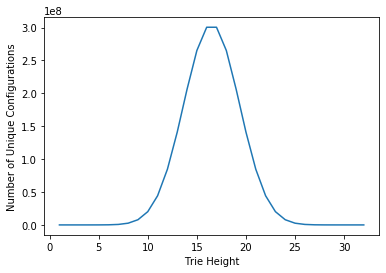

In [43]:
def choose(n, k):
    return factorial(n) / factorial(k) / factorial(n - k)

x = [i for i in range(1, 33)]
y = [choose(31, n - 1) for n in x]
plt.figure(0)
plt.xlabel("Trie Height")
plt.ylabel("Number of Unique Configurations")
choose_plt, = plt.plot(x,y)

In [ ]:
all_4_to_8 = pd.read_csv('all_configs_from_4_to_8_levels_max_8bit.csv', sep=';')
all_4_to_8 = append_stats_to_df(all_4_to_8)

In [ ]:
all_4_to_8 = all_4_to_8.sort_values('RandomMatch')
all_4_to_8[['Config', 'MaxNodeSize', 'MaxAverageNodeSize', 'AverageNodeSize', 'RandomMatch', 'Match','TreeMemoryUniqueOnly', 'Build', 'EmptyPointerLevels']]

In [ ]:
x = all_4_to_8['MaxNodeSize'].values
y = all_4_to_8['RandomMatch'].values
z = all_4_to_8['Match'].values
plt.title("MaxNodeSize Vs RandomMatch LPM algorithm execution Time")
plt.xlabel("Max Node Size (number of keys per node)")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()

all_4_to_8 = all_4_to_8.sort_values('RandomMatch')
all_4_to_8[['AverageNodeSize', 'RandomMatch']]

In [ ]:
x = all_4_to_8['MaxAverageNodeSize'].values
y = all_4_to_8['RandomMatch'].values
z = all_4_to_8['Match'].values
plt.title("AverageNodeSize Vs RandomMatch LPM algorithm execution Time")
plt.xlabel("Average Node Size (number of keys per node)")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()

all_4_to_8 = all_4_to_8.sort_values('RandomMatch')
all_4_to_8[['AverageNodeSize', 'RandomMatch']]

In [ ]:
x = all_4_to_8['Depth'].values
y = all_4_to_8['RandomMatch'].values
z = all_4_to_8['AverageNodeSize'].values
plt.title("Depth Vs RandomMatch LPM algorithm execution Time")
plt.xlabel("Number of levels (depth)")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()